In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
from google.colab import files
import io
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings(action='ignore')

### We will give you the preproceesed titanic data.
### File is on your Icampus, Please download train_preprocessed.csv
### It is preprocessed based on last week's lab.

In [2]:
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['train_preprocessed.csv']))

Saving train_preprocessed.csv to train_preprocessed.csv


In [3]:
train, test = train_test_split(data, test_size = 0.1, random_state = 55)

### 1. Optimization Method
#### So far, we only used SGD to update our weights! There are more optimization functions below..
![title](https://ifh.cc/g/WKrDPD.jpg)

In [4]:
# Momentum is caring about the past gradient and uses the past gradient as well!
# momentum can be assigned in the SGD function torch implemented
MLP1 = torch.nn.Linear(3, 1)
optimizer = torch.optim.SGD(MLP1.parameters(), lr= 0.001, momentum=0.9)

In [5]:
# RMSProp adjusts the learning rate for each weight, if the gradient was large at the past history, learning rate becomes smallar
# RMSProp 
optimizer = torch.optim.RMSprop(MLP1.parameters(), lr =0.001)

In [6]:
# Adam is somewhat having characteristics of both the momentum and RMSProp as you can figure out in the figure
optimizer = torch.optim.Adam(MLP1.parameters(), lr = 0.001)

### For today's lecture, we will use Adam optimizer

In [7]:
x_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']
x_test = test.drop(['Survived'], axis=1)
y_test = test['Survived']

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [9]:
x_train = torch.FloatTensor(x_train.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy())
y_train = y_train.reshape(-1, 1)
x_test = torch.FloatTensor(x_test.to_numpy())
y_test = torch.FloatTensor(y_test.to_numpy())
y_test = y_test.reshape(-1, 1)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## Let's recall last week's titanic_layer

In [10]:
class Titanic_layer(torch.nn.Module):
  def __init__(self):
    super(Titanic_layer, self).__init__()
    ## define your own layers! 
    self.MLP1 = torch.nn.Linear(10, 32)
    self.MLP2 = torch.nn.Linear(32, 64)
    self.MLP3 = torch.nn.Linear(64, 32)
    self.MLP4 = torch.nn.Linear(32, 16)
    self.MLP5 = torch.nn.Linear(16, 4)
    self.MLP6 = torch.nn.Linear(4, 1)

  def forward(self, x):
    # define the forward function
    y = self.MLP1(x)
    y = torch.nn.functional.relu(y) # we will use relu as our activation function. relu has advantage when layers go deeper!
    y = self.MLP2(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP3(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP4(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP5(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP6(y)
    y = torch.nn.functional.sigmoid(y) #last element should be with 0~1, therefore, we can't use relu
    return y

In [11]:
epochs =  800      # please write your own epoch
model = Titanic_layer()
loss_func = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.01)
train_loss = []
test_loss = []
batch_len = len(train_dataloader)
for epoch in range(1, epochs+1):
  train_acc = 0
  train_total = 0
  test_acc = 0
  test_total = 0
  for i, data in enumerate(train_dataloader):
    x, target = data
    model.train() # this code indicates that model is in training mode
    y = model(x)
    loss = loss_func(y, target)
    real_y = (y>=0.5).float()
    train_acc += (real_y == target).float().sum()
    train_total += target.shape[0]
    optim.zero_grad()
    loss.backward()
    optim.step()
  for i, data in enumerate(test_dataloader):
    x, target = data
    model.eval() # this code indicates that model is in evaluation mode
    with torch.no_grad():
      y = model(x)
      loss = loss_func(y, target)
      real_y = (y>=0.5).float()
      test_acc += (real_y == target).float().sum()
      test_total += target.shape[0]
  train_loss.append(train_acc/train_total)
  test_loss.append(test_acc/test_total)

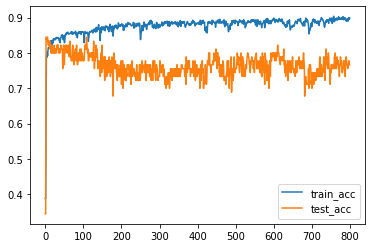

In [12]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_loss)), train_loss, label='train_acc')
plt.plot(np.arange(len(test_loss)), test_loss, label='test_acc')
plt.legend()
plt.show()

#### As you can find out from the figure above, train_acc keeps increasing while test_acc becomes degrading.
#### This is called overfitting. It fits too well to the training dataset not giving right accuracy to the test dataset.
#### From now on, we will learn some useful tips to avoid overfitting.

## 2. Dropout
#### We randomly make some weights to 0 so this weights aren't used in training and also updating
#### We can use dropout like this
```python
dropout = torch.nn.Dropout(p=0.5)
dropout(input)
```


#### Problem 1: use nn.Dropout on our previous titanic_layer and find out the difference of our plot! (10 points)

In [45]:
class Titanic_layer(torch.nn.Module):
  def __init__(self):
    super(Titanic_layer, self).__init__()
    ## define your own layers! 
    self.MLP1 = torch.nn.Linear(10, 32)
    self.MLP2 = torch.nn.Linear(32, 64)
    self.MLP3 = torch.nn.Linear(64, 32)
    self.MLP4 = torch.nn.Linear(32, 16)
    self.MLP5 = torch.nn.Linear(16, 4)
    self.MLP6 = torch.nn.Linear(4, 1)

    # write down the dropout as you want
    self.drop_high = torch.nn.Dropout(p=0.7)
    self.drop_low = torch.nn.Dropout(p=0.5)

  def forward(self, x):
    # define the forward function
    # use the dropout function after the activation function
    y = self.MLP1(x)
    y = torch.nn.functional.relu(y) # we will use relu as our activation function. relu has advantage when layers go deeper!
    y = self.MLP2(y)
    y = torch.nn.functional.relu(y)

    y = self.drop_low(y) # for many weight, I use low rate dropout

    y = self.MLP3(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP4(y)
    y = torch.nn.functional.relu(y)

    y = self.drop_high(y) # for few weight, I use high rate dropout

    y = self.MLP5(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP6(y)
    y = torch.nn.functional.sigmoid(y) #last element should be with 0~1, therefore, we can't use relu
    return y

In [46]:
epoches =  800      # please write your own number of epoch
model = Titanic_layer()
loss_func = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.01)
train_loss = []
test_loss = []
batch_len = len(train_dataloader)
for epoch in range(1, epoches+1):
  train_acc = 0
  train_total = 0
  test_acc = 0
  test_total = 0
  for i, data in enumerate(train_dataloader):
    x, target = data
    model.train() # this code indicates that model is in training mode
    y = model(x)
    loss = loss_func(y, target)
    real_y = (y>=0.5).float()
    train_acc += (real_y == target).float().sum()
    train_total += target.shape[0]
    optim.zero_grad()
    loss.backward()
    optim.step()
  for i, data in enumerate(test_dataloader):
    x, target = data
    model.eval() # this code indicates that model is in evaluation mode
    with torch.no_grad():
      y = model(x)
      loss = loss_func(y, target)
      real_y = (y>=0.5).float()
      test_acc += (real_y == target).float().sum()
      test_total += target.shape[0]
  train_loss.append(train_acc/train_total)
  test_loss.append(test_acc/test_total)

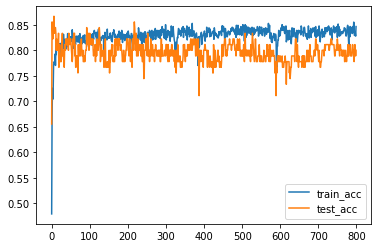

In [47]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_loss)), train_loss, label='train_acc')
plt.plot(np.arange(len(test_loss)), test_loss, label='test_acc')
plt.legend()
plt.show()

## 3. Hyper-parameter tuning: Split data into Train, Validation, Test dataset
- To update the performace of models, we can tune our model of hyper-parameters. 
- The validation dataset is used for hyper-parameters tuning, not test datset. (Note: A test dataset is only used for a final evalutation) 
- We can split the train dataset into train and validation dataset.


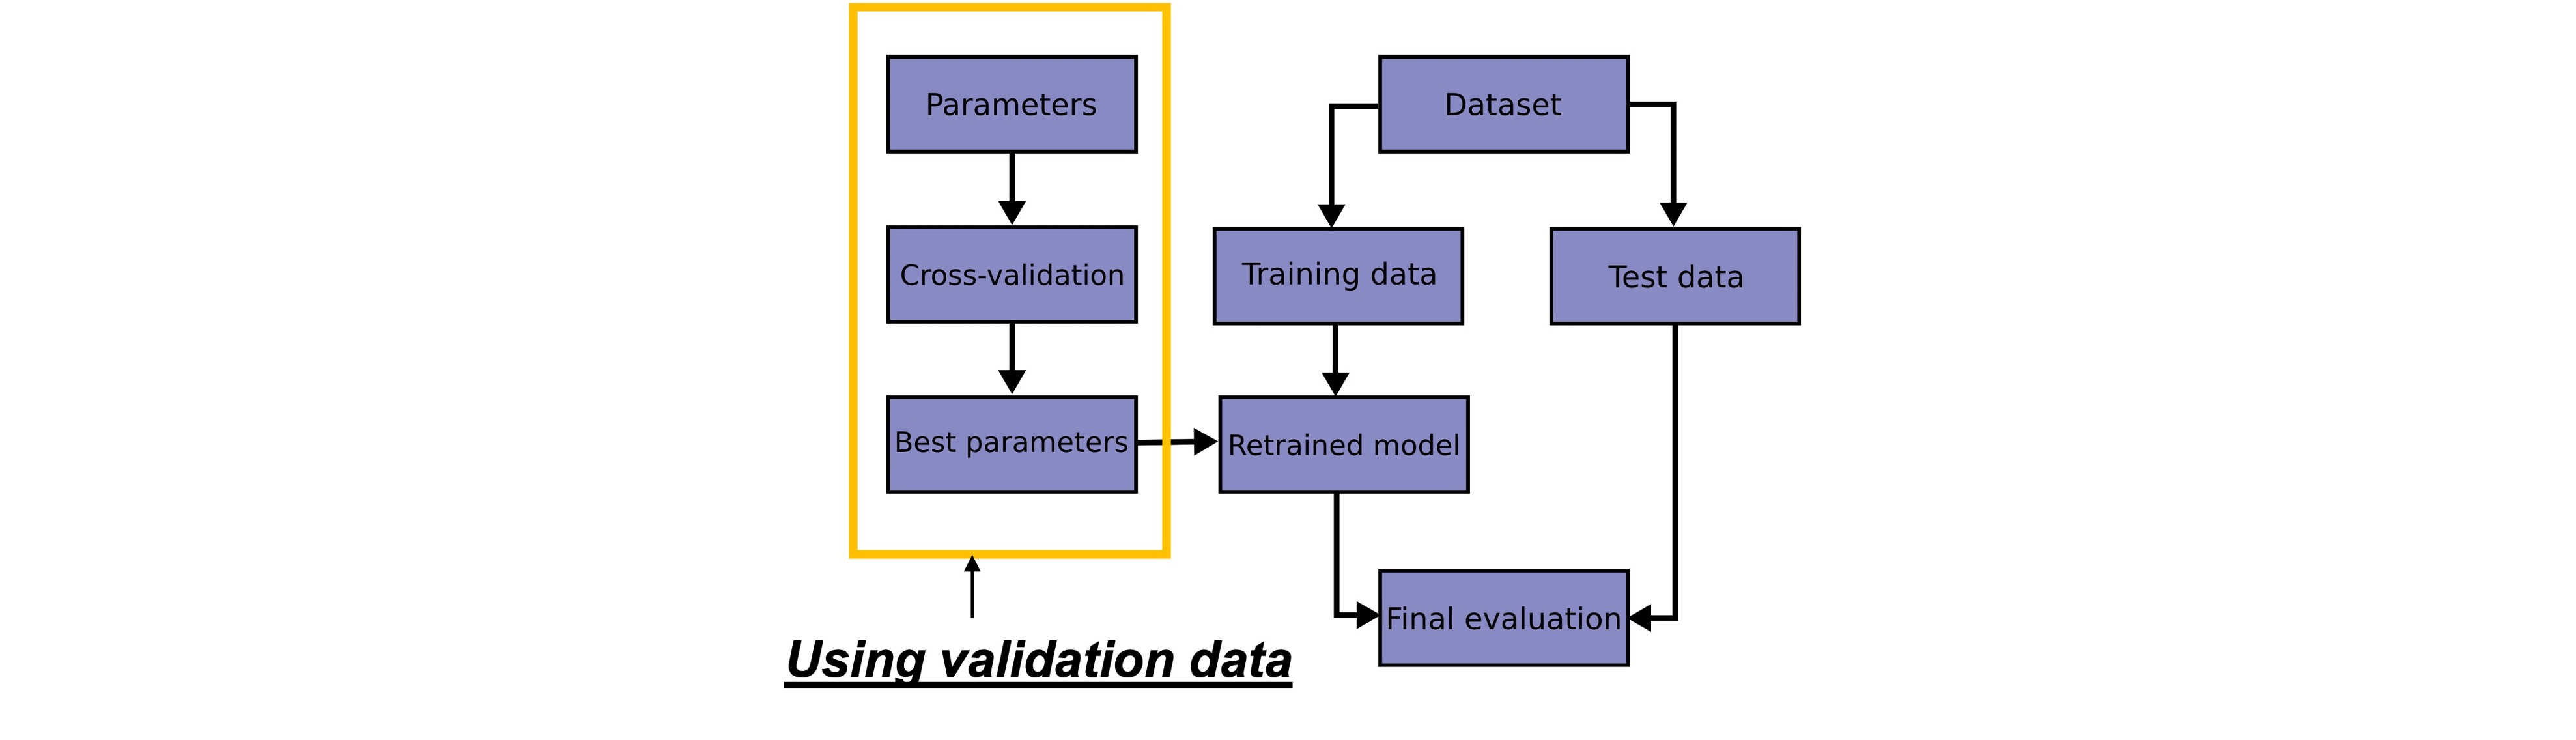

In [48]:
from sklearn.model_selection import KFold
dataset = np.array(train.index)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(dataset):
  display(train.loc[dataset[train_idx]].head(3))

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
768,0,1.0,0.310639,1,0,0.047138,0,1,0,1,0
598,0,1.0,0.310639,0,0,0.014102,0,1,1,0,0
294,0,1.0,0.296306,0,0,0.015412,0,1,0,0,1


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
598,0,1.0,0.310639,0,0,0.014102,0,1,1,0,0
26,0,1.0,0.310639,0,0,0.014102,0,1,1,0,0
780,1,1.0,0.158080,0,0,0.014110,1,0,1,0,0


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
768,0,1.0,0.310639,1,0,0.047138,0,1,0,1,0
26,0,1.0,0.310639,0,0,0.014102,0,1,1,0,0
294,0,1.0,0.296306,0,0,0.015412,0,1,0,0,1


## 4. Hyper-parameters tuning: cross-validated grid-search
When we split data into three sets, there is a risk of sampling bias(over-estimation or under-estimation), but also a limit to utilize the only part of dataset. A cross-validation (CV for short) is used as the solution for this problem. [Reference](https://scikit-learn.org/stable/modules/cross_validation.html)

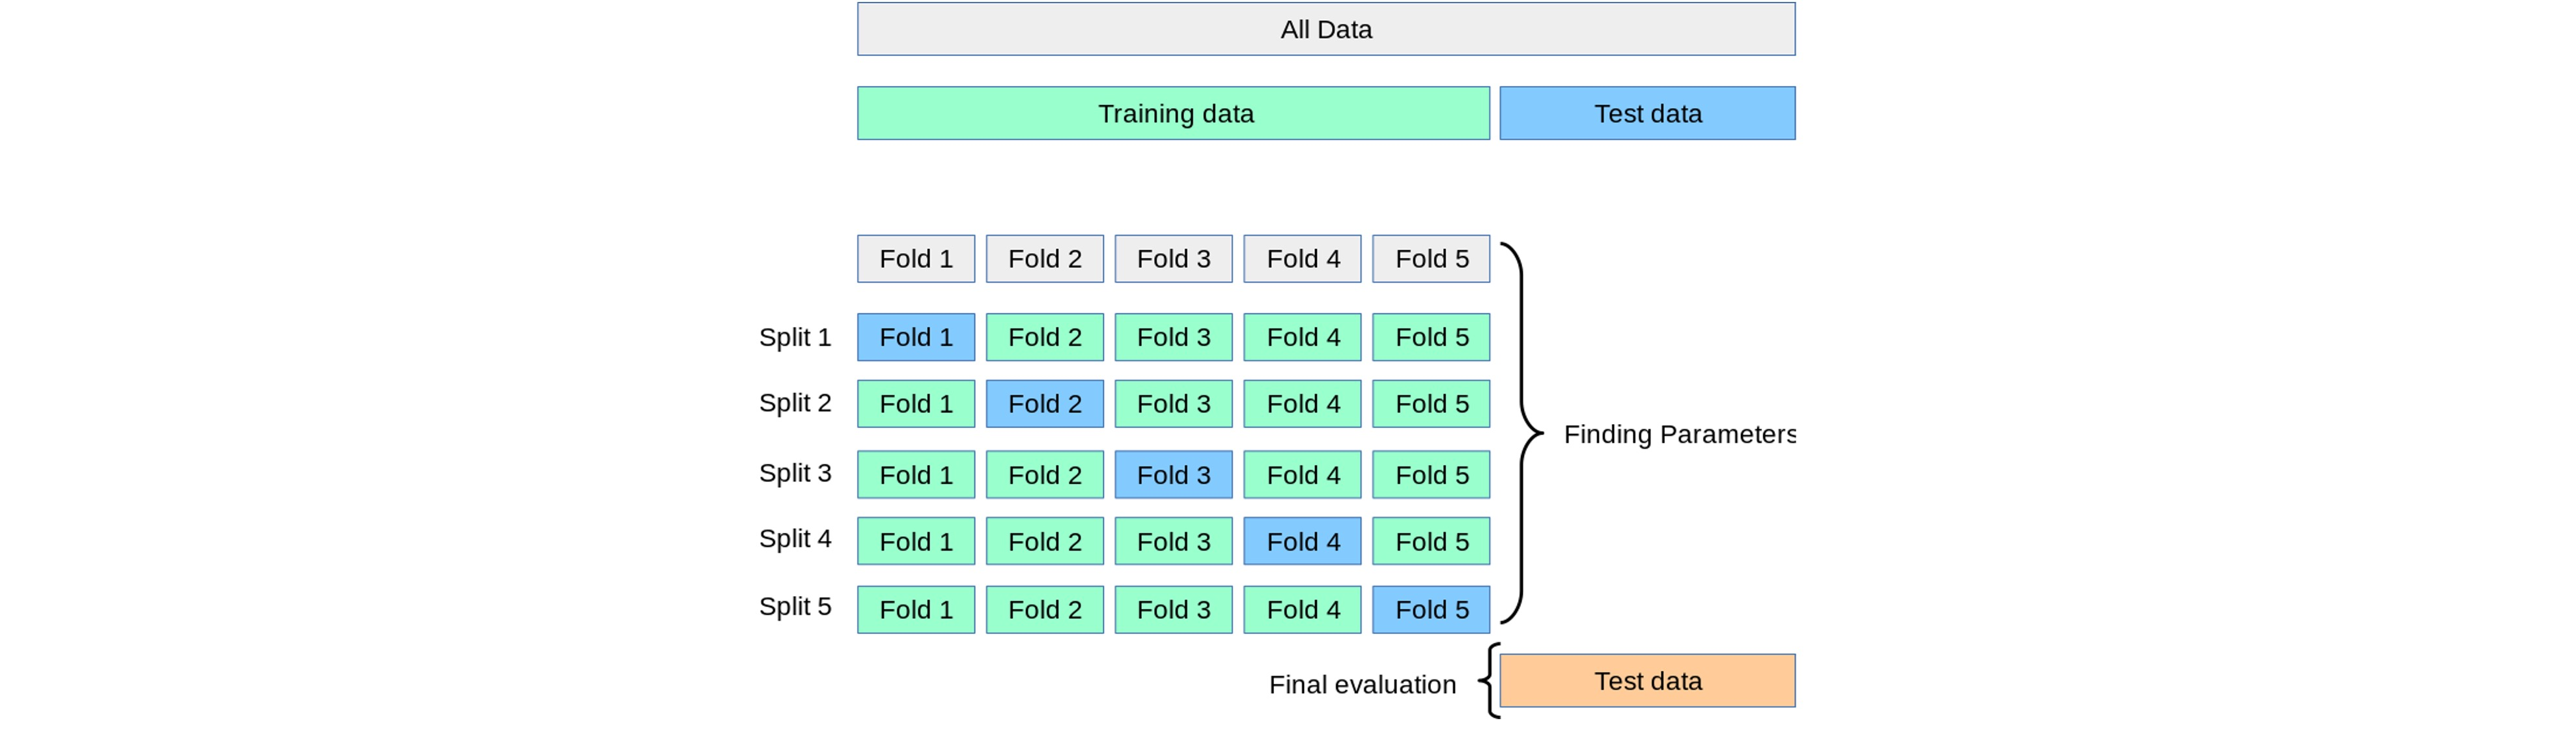

To tune multiple hyper-parameters, we can use [***cross-validated grid-search*** ](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)method.
1. Select the hyper-parameters which you want to tune.
2. Set the candidate values for each hyper-parameters.
3. Apply into model using grid search method
3. Return the best set of hyper-parameters for the model.


In [65]:
# The goal of skorch is to make it possible to use PyTorch with sklearn. 
# This is achieved by providing a wrapper around PyTorch that has an sklearn interface.
# https://skorch.readthedocs.io/en/stable/index.html
!pip install skorch

In [67]:
X = np.array(train.drop(['Survived'], axis=1)).astype(np.float32)
y = np.array(train['Survived']).astype(np.float32).reshape(-1, 1)

In [66]:
def my_accuracy(net, X, y):
  real_y = (net.predict_proba(X)>=0.5)
  val_acc = (real_y == y).sum()
  val_total = y.shape[0]
  return (val_acc/val_total)

In [53]:
from skorch import NeuralNet

net = NeuralNet(Titanic_layer, 
                max_epochs = 20, 
                lr=0.01, 
                criterion=torch.nn.BCELoss, 
                optimizer=torch.optim.Adam, 
                verbose=0,
                device='cuda')
net.fit(X, y)
print(f'Accuracy of training dataset: {my_accuracy(net, X, y): .2f}%')

Accuracy of training dataset:  0.83%


In [54]:
# 1. Select the hyper-parameters which you want to tune
print(net.get_params().keys())

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 'verbose', 'device', '_kwargs', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__name', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__valid_loss', 'callbacks__valid_loss__name', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__print_log', 'callbacks__print_log__keys_ignored', 'callbacks__print_log__sink', 'callbacks__print_log__tablefmt', 'callbacks__print_log__floatfmt', 'callbacks__print_log__stralign'])


In [55]:
# 2. Set the candidate values for each hyper-parameters.
params = {'optimizer':[torch.optim.Adam,torch.optim.RMSprop],
          'lr':[0.001, 0.005, 0.01]}

In [57]:
# 3. Apply into model using cross validated grid search method
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=net, 
                  param_grid=params,
                  scoring=my_accuracy, 
                  cv=3, 
                  verbose=0)

gs.fit(X, y)
# 4. Return the best set of hyper-parameters for the model.
print(f'Accuracy: {gs.best_score_ * 100 :.2f}%')
print(gs.best_params_)

Accuracy: 80.27%
{'lr': 0.005, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [58]:
gs.cv_results_['params']

[{'lr': 0.001, 'optimizer': torch.optim.adam.Adam},
 {'lr': 0.001, 'optimizer': torch.optim.rmsprop.RMSprop},
 {'lr': 0.005, 'optimizer': torch.optim.adam.Adam},
 {'lr': 0.005, 'optimizer': torch.optim.rmsprop.RMSprop},
 {'lr': 0.01, 'optimizer': torch.optim.adam.Adam},
 {'lr': 0.01, 'optimizer': torch.optim.rmsprop.RMSprop}]

In [59]:
gs.cv_results_["mean_test_score"]

array([0.70536829, 0.79275905, 0.80274657, 0.79525593, 0.78901373,
       0.7752809 ])

### Problem 2: Using cross-validated grid search method, decide the proper size of epochs to avoid overfitting.(10 points)
In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration. 
([Reference](https://en.wikipedia.org/wiki/Early_stopping))

In [70]:
# You can refer the above plot of accuray to decide the range of epochs
params = {'max_epochs': [30, 35 ,40], 
          'lr':[0.001, 0.005, 0.01]}
# Cross-validate 10, 50, 100 epochs -> 30, 50, 70 epochs -> 30, 35, 40 epochs
gs = GridSearchCV(estimator=net, 
                  param_grid=params,
                  scoring=my_accuracy, 
                  cv=3, 
                  verbose=0)

gs.fit(X, y)

print(f'Accuracy: {gs.best_score_ * 100 :.2f}%')
print(gs.best_params_)

Accuracy: 81.15%
{'lr': 0.005, 'max_epochs': 40}


## 5. Final model

### Problem 3: Evaluate your model applying K-fold Cross-validation with optimal hyper-parameters which you found (10 points)

In [71]:
from torch.utils.data import SubsetRandomSampler

kf = KFold(n_splits=3, shuffle=True, random_state=42)


df = pd.read_csv(io.BytesIO(uploaded['train_preprocessed.csv']))
X_df = df.drop(['Survived'], axis=1)
y_df = df['Survived']

X_df = torch.FloatTensor(X_df.to_numpy())
y_df= torch.FloatTensor(y_df.to_numpy()).reshape(-1, 1)

dataset = TensorDataset(X_df, y_df)

Fold 1


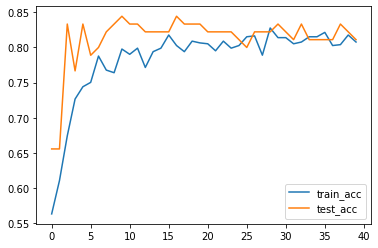

Fold 2


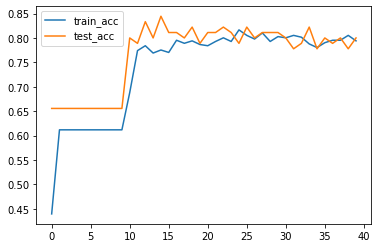

Fold 3


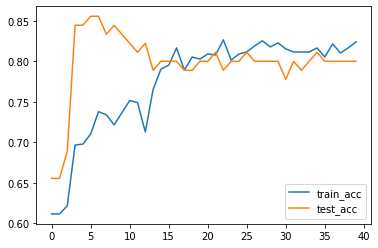

Fold 4


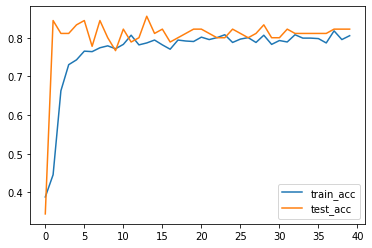

Fold 5


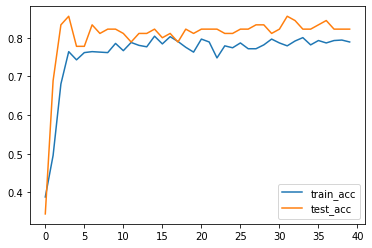

Average Accuracy of train dataset: 78.90%
Average Accuracy of test dataset: 82.22%


In [72]:
optimal_epochs = 40
optimal_lr = 0.005

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx,val_idx) in enumerate(kf.split(range(len(df)))):

  print('Fold {}'.format(fold + 1))
  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(val_idx)
  train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
  test_loader = DataLoader(dataset, batch_size=64, sampler=test_sampler)

  model = Titanic_layer()
  loss_func = torch.nn.BCELoss()
  optim = torch.optim.Adam(model.parameters(), lr = optimal_lr)

  history = {'train_acc':[],'test_acc':[]}
    
  train_acc_lst = []
  test_acc_lst = []

  for epoch in range(1, optimal_epochs+1):
    train_acc = 0
    train_total = 0
    test_acc = 0
    test_total = 0

    for i, data in enumerate(train_dataloader):
      x, target = data
      model.train() # this code indicates that model is in training mode
      y = model(x)
      loss = loss_func(y, target)
      real_y = (y>=0.5).float()
      train_acc += (real_y == target).float().sum()
      train_total += target.shape[0]
      optim.zero_grad()
      loss.backward()
      optim.step()

    for i, data in enumerate(test_dataloader):
      x, target = data
      model.eval() # this code indicates that model is in evaluation mode
      with torch.no_grad():
        y = model(x)
        loss = loss_func(y, target)
        real_y = (y>=0.5).float()
        test_acc += (real_y == target).float().sum()
        test_total += target.shape[0]

    train_acc_lst.append(train_acc/train_total)
    test_acc_lst.append(test_acc/test_total)

  plt.plot(np.arange(len(train_acc_lst)), train_acc_lst, label='train_acc')
  plt.plot(np.arange(len(test_acc_lst)), test_acc_lst, label='test_acc')
  plt.legend()
  plt.show()

  history['train_acc'].append(train_acc_lst[-1])
  history['test_acc'].append(test_acc_lst[-1])

avg_acc_train = np.mean(history['train_acc'])
avg_acc_test = np.mean(history['test_acc'])
print(f'Average Accuracy of train dataset: {avg_acc_train * 100 :.2f}%')
print(f'Average Accuracy of test dataset: {avg_acc_test * 100 :.2f}%')